In [ ]:
%%capture
!pip install xgboost==1.7.1 scikit-learn==1.5.2

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
data = yf.download('RELIANCE.NS', end = '2024-12-24')

In [ ]:
series = data['Close']

In [ ]:
# Create lag features
def create_lagged_features(series, lag=3):
    df = pd.DataFrame()
    for i in range(lag, 0, -1):
        df[f'lag_{i}'] = series.shift(i)
    df['target'] = series
    return df.dropna()

lagged_data = create_lagged_features(series, lag=3)
X = lagged_data.drop('target', axis=1)
y = lagged_data['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)

# Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Building the XGBoost Model

In [ ]:
model = xgb.XGBModel(objective='reg:squarederror')
model.fit(X_train, y_train)


XGBModel(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
         grow_policy='depthwise', interaction_constraints='',
         learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
         max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
         min_child_weight=1, monotone_constraints='()', n_jobs=0,
         num_parallel_tree=1, objective='reg:squarederror', predictor='auto',
         random_state=0, reg_alpha=0, reg_lambda=1, sampling_method='uniform',
         scale_pos_weight=1, subsample=1, tree_method='exact',
         validate_parameters=1)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
XGB_error = mean_squared_error(y_test, y_pred)
XGB_error = np.sqrt(XGB_error)
print(f'XGBoost Error: {XGB_error}')


XGBoost Error: 542.9838541678515


In [ ]:
XGB_predictions = pd.Series(y_pred.flatten(), index=y_test.index)

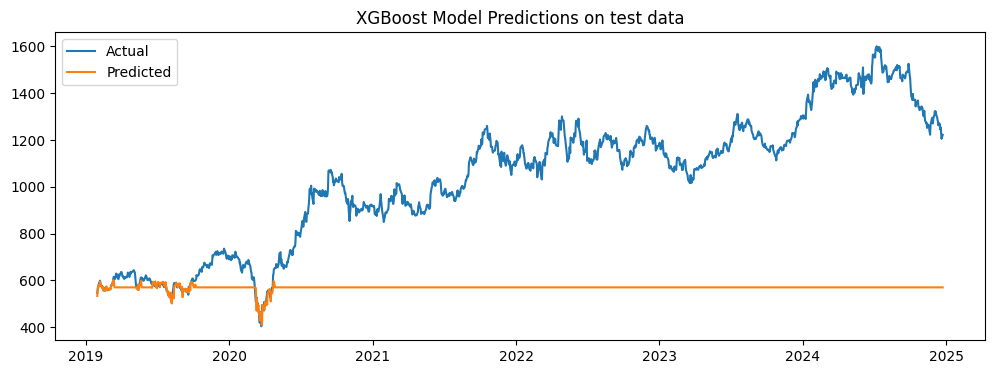

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(y_test, label='Actual')
plt.plot(XGB_predictions, label='Predicted')
plt.legend()
plt.title("XGBoost Model Predictions on test data")
plt.show()

In [ ]:
# Get the last `lag` days from the series for initial input
last_lagged_data = series[-3:].values
print(last_lagged_data) # Assuming lag=3
future_predictions = []

# Iterate for 30 days to predict future values
for _ in range(30):
    # Create the input feature for the model
    scaled_input = scaler.transform(last_lagged_data.reshape(1, -1))

    # Predict the next value
    next_prediction = model.predict(scaled_input)

    # Append the prediction to the future predictions list
    future_predictions.append(next_prediction[0]) # Changed this line

    # Update the input data by removing the first value and appending the prediction
    last_lagged_data = np.append(last_lagged_data[1:], next_prediction)

# Get the last `lag` days from the series for initial input
last_lagged_data = series[-3:].values
print(last_lagged_data) # Assuming lag=3
future_predictions = []

# Iterate for 30 days to predict future values
for _ in range(30):
    # Create the input feature for the model
    scaled_input = scaler.transform(last_lagged_data.reshape(1, -1))

    # Predict the next value
    next_prediction = model.predict(scaled_input)

    # Append the prediction to the future predictions list
    future_predictions.append(next_prediction[0])  # Changed this line

    # Update the input data by removing the first value and appending the prediction
    last_lagged_data = np.append(last_lagged_data[1:], next_prediction)

print(future_predictions)
# Reshape to have 3 features instead of 1
future_predictions_reshaped = np.array(future_predictions).reshape(-1, 1)
future_predictions_reshaped = np.repeat(future_predictions_reshaped, 3, axis=1)


# # Reverse the scaling to get actual stock prices using the reshaped array
future_predictions_actual = future_predictions_reshaped[:,0] #extract first column which was used for target variable

# Create a date range for future predictions
future_dates = pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=30)

# Prepare a DataFrame for visualization
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions_actual.flatten()
})
future_df.set_index('Date', inplace=True)

[[1230.44995117]
 [1205.30004883]
 [1222.30004883]]
[[1230.44995117]
 [1205.30004883]
 [1222.30004883]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

[570.45, 565.07275, 564.62683, 558.86914, 559.8028, 559.06775, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327, 559.4327]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

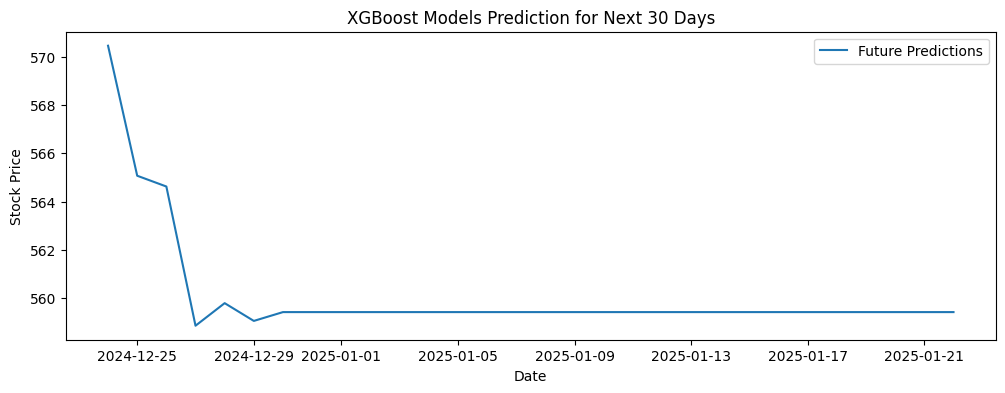

In [ ]:
# Visualize the future predictions
plt.figure(figsize=(12, 4))
plt.plot(future_df, label='Future Predictions')
plt.legend()
plt.title('XGBoost Models Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


## Building the Random Forest Model

In [ ]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
RandomForest_error = mean_squared_error(y_test, y_pred)
RandomForest_error = np.sqrt(RandomForest_error)
print(f'RandomForest Error: {RandomForest_error}')

RandomForest Error: 531.3527309188667


In [ ]:
RandomForest_predictions = pd.Series(y_pred.flatten(), index=y_test.index)

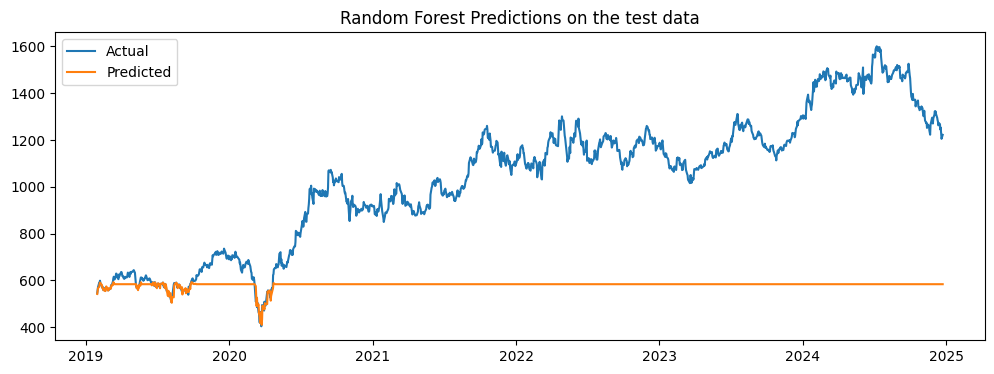

In [ ]:
plt.figure(figsize = (12,4))
plt.plot(y_test, label='Actual')
plt.plot(RandomForest_predictions, label='Predicted')
plt.legend()
plt.title("Random Forest Predictions on the test data")
plt.show()

In [ ]:
# Get the last `lag` days from the series for initial input
last_lagged_data = series[-3:].values
print(last_lagged_data) # Assuming lag=3
future_predictions = []

# Iterate for 30 days to predict future values
for _ in range(30):
    # Create the input feature for the model
    scaled_input = scaler.transform(last_lagged_data.reshape(1, -1))

    # Predict the next value
    next_prediction = model.predict(scaled_input)

    # Append the prediction to the future predictions list
    future_predictions.append(next_prediction[0]) # Changed this line

    # Update the input data by removing the first value and appending the prediction
    last_lagged_data = np.append(last_lagged_data[1:], next_prediction)

# Get the last `lag` days from the series for initial input
last_lagged_data = series[-3:].values
print(last_lagged_data) # Assuming lag=3
future_predictions = []

# Iterate for 30 days to predict future values
for _ in range(30):
    # Create the input feature for the model
    scaled_input = scaler.transform(last_lagged_data.reshape(1, -1))

    # Predict the next value
    next_prediction = model.predict(scaled_input)

    # Append the prediction to the future predictions list
    future_predictions.append(next_prediction[0])  # Changed this line

    # Update the input data by removing the first value and appending the prediction
    last_lagged_data = np.append(last_lagged_data[1:], next_prediction)

print(future_predictions)
# Reshape to have 3 features instead of 1
future_predictions_reshaped = np.array(future_predictions).reshape(-1, 1)
future_predictions_reshaped = np.repeat(future_predictions_reshaped, 3, axis=1)


# # Reverse the scaling to get actual stock prices using the reshaped array
future_predictions_actual = future_predictions_reshaped[:,0] #extract first column which was used for target variable

# Create a date range for future predictions
future_dates = pd.date_range(series.index[-1] + pd.Timedelta(days=1), periods=30)

# Prepare a DataFrame for visualization
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_predictions_actual.flatten()
})
future_df.set_index('Date', inplace=True)

[[1230.44995117]
 [1205.30004883]
 [1222.30004883]]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

[[1230.44995117]
 [1205.30004883]
 [1222.30004883]]
[584.0053399658203, 579.0951501464843, 576.8680639648437, 577.596318359375, 577.5005419921876, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578, 577.6852374267578]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScal

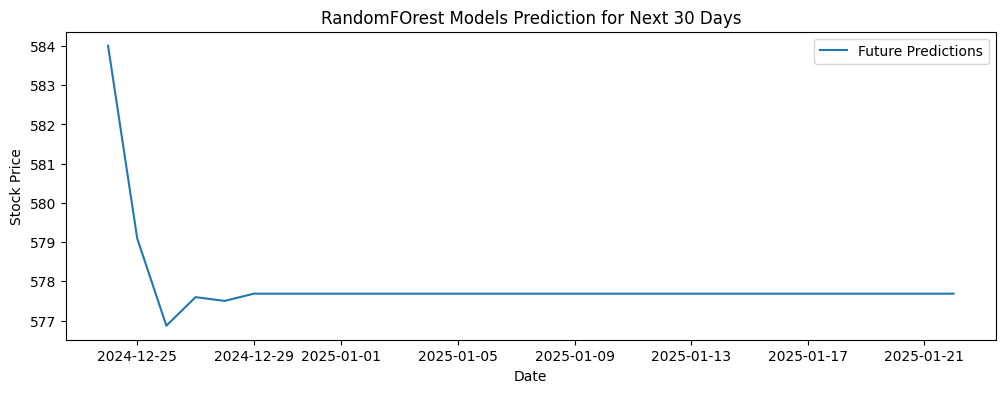

In [ ]:
# Visualize the future predictions
plt.figure(figsize=(12, 4))
plt.plot(future_df, label='Future Predictions')
plt.legend()
plt.title('RandomFOrest Models Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


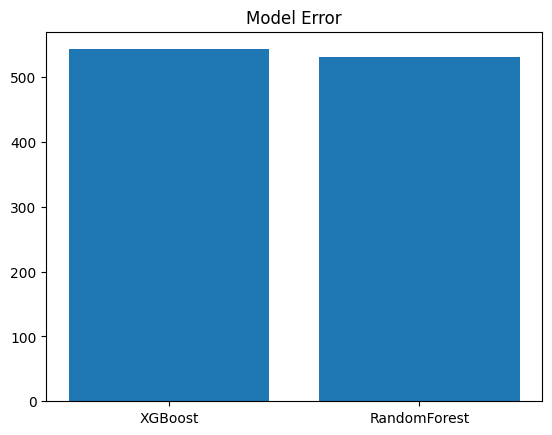

In [ ]:
err = [XGB_error,RandomForest_error]
model_name = ['XGBoost','RandomForest']
plt.bar(model_name,err)
plt.title("Model Error")
plt.show()